In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import textstat
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sakshisinha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
with open('final_dataset.json', 'r') as f:
    data_json = json.load(f)

# Assuming data_json is a list of dicts
records = []
for item in data_json:
    user_id = item['user_id']
    headline = item['profile_data']['headline']
    bio = item['profile_data']['bio']
    verdict = item['verdict']  # label
    records.append({'user_id': user_id, 'headline': headline, 'bio': bio, 'verdict': verdict})

df = pd.DataFrame(records)

In [3]:
# 2. Preprocessing and Feature Engineering

# Combine headline and bio text into one feature column
df['text'] = df['headline'] + " " + df['bio']

# Function to clean text (simple)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # remove non-alphanumeric
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Compute readability score using textstat
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

# Simple buzzword list example (you can expand)
buzzwords = ['growth', 'branding', 'strategist', 'seo', 'content', 'copywriter', 'lead', 'business']

def buzzword_overlap(text):
    words = set(text.split())
    overlap = len(words.intersection(set(buzzwords)))
    return overlap

df['buzzword_overlap'] = df['clean_text'].apply(buzzword_overlap)

In [4]:
df['label'] = df['verdict'].apply(lambda x: 1 if x == 'authentic' else 0)  # 1: authentic, 0: fake/exaggerated


In [5]:
# 4. Feature extraction: TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords.words('english'), max_features=5000)
X_text = vectorizer.fit_transform(df['clean_text'])

In [6]:
# Combine TF-IDF features with numeric features
import scipy.sparse as sp

X_numeric = df[['readability', 'buzzword_overlap']].values
X = sp.hstack([X_text, X_numeric])

y = df['label'].values

In [7]:
# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [8]:
# 6. Model training: Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
# 7. Prediction & evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuracy: 0.818
Precision: 0.800
Recall: 1.000
F1-score: 0.889
ROC AUC: 0.833


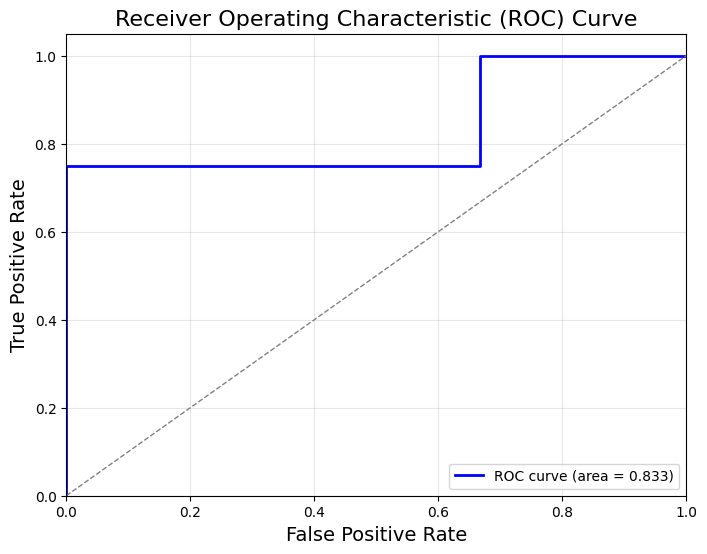

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute false positive rate (fpr), true positive rate (tpr), thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


<Figure size 600x600 with 0 Axes>

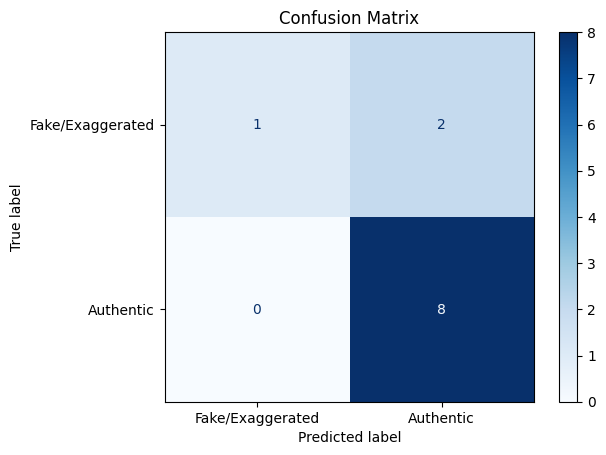

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake/Exaggerated', 'Authentic'])

# Plot the confusion matrix
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [16]:
import os
import joblib

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model and vectorizer inside models folder
joblib.dump(clf, 'models/model2.pkl')
joblib.dump(vectorizer, 'models/vectorizer2.pkl')
print("Model saved")

Model saved
